 #### **Установка всех необходимых библиотек**

In [1]:
from google.colab import files
from IPython.display import clear_output

files.upload()
clear_output()

In [2]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [3]:
!chmod 600 kaggle.json
!cp kaggle.json ~/.kaggle/

# ДЗ 1
## Классический МЛ в NLP, вспомнить все!

В этом ДЗ будем работать с датасетом Men_Women_Shoes_Reviews https://www.kaggle.com/daishinkan002/men-women-shoes-reviews 

## *Что нужно сделать в каждом задании:* 
1) проанализировать данные (все, на что хватит вашей фантазии, хороший анализ включает в себя графики и статистические инструменты анализа, можно приходить с вопросами "какой инструмент поможет мне проверить такую-то гипотезу/хочу посмотреть вот это вот, как это сделать", предварительно не стесняйтесь гуглить) **1 балл**

2) подготовить данные (стемминг, лемматизация, убрать мусор и стоп-слова, нормализовать... все, что покажется вам разумным относительно данных, но вы должны кратко (комментарием к этому блоку кода в тетрадке) объяснить почему вы сделали именно такой препроцессинг. Хороший препроцессинг - разумный, в данном случае чем больше тем не всегда лучше) **1 балла**

3) векторизовать тексты (контекстуальные эммбединги пока что не берем, только BoW и TF-IDF) **0.5 балл**

4) сделать гридсерч по нескольким моделям (у нас 2 задания, классификация и регрессия), подобрать гиперпараметры, выбрать лучшую модель, рассказать, почему, на ваш взгляд, лучший результат показал лучший алгоритм **1 балл**

5) оценить и проанализировать качество лучших решений для каждой задачи (рассказать с чем ваша модель справляется хорошо, а где у нее "слабые места", можно ли как-то улучшить ваши результаты. Хороший анализ сопровождается графиками) **1,5 балла** 

Максимальная сумма баллов при выполнении 5 пунктов в 2 заданиях - 10

В тетрадке с первого занятия много дополнительной информации, которая может вам помочь, но все равно не стесняйтесь приходить с вопросами в чат курса. 

#### **Скачивание данных**

In [4]:
!kaggle datasets download -d daishinkan002/men-women-shoes-reviews

  0% 0.00/262k [00:00<?, ?B/s]
100% 262k/262k [00:00<00:00, 76.8MB/s]


In [5]:
!unzip men-women-shoes-reviews.zip
!rm -rf men-women-shoes-reviews.zip

Archive:  men-women-shoes-reviews.zip
  inflating: Shoes_Data.csv          


 #### **Импорт библиотек**

In [91]:
import re
from collections import defaultdict, Counter
from itertools import chain
from string import punctuation
from typing import List, Tuple

import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from wordcloud import WordCloud

%matplotlib inline
plt.rcParams["figure.figsize"] = (18, 6)

In [7]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [8]:
stop = set(stopwords.words("english"))

In [9]:
lemmatizer = WordNetLemmatizer()

#### **Функции для обработки текста**

In [10]:
emoji_pattern = re.compile("["
u"\U0001F600-\U0001F64F"  # emoticons
u"\U0001F300-\U0001F5FF"  # symbols & pictographs
u"\U0001F680-\U0001F6FF"  # transport & map symbols
u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
u"\U00002702-\U000027B0"
u"\U000024C2-\U0001F251"
"]+", flags=re.UNICODE)

In [11]:
def clean_text(text: str) -> str:
    """
    Функция для препроцессинга текстов.
    Приводит текст к нижнему регистру,
    удаляет пунктуацию (кроме символа |, т. к.,
    это разделитель между текстами отзывов),
    цифры и не-ASCII символы, проводит лемматизацию.

    Parameters:
        text: str

    Returns:
        str
    """
    text = text.lower()
    text = text.translate(str.maketrans("", "", punctuation.replace("|", "")))
    text = re.sub(r"\d+", "", text)
    text = emoji_pattern.sub(r"", text)
    text = text.encode("ascii", "ignore").decode()
    return " ".join(
        [lemmatizer.lemmatize(word) for word in word_tokenize(text)]
        )

In [12]:
def remove_stopwords(text: str) -> str:
    """
    Функция, удаляющая стоп-слова из текста.

    Parameters:
        text: str

    Returns:
        str
    """
    return " ".join([word for word in word_tokenize(text) if word not in stop])

In [13]:
def create_corpus(texts: List[str]) -> List[str]:
    """
    Функция, получающая на вход список текстов
    и возвращающая список встречающихся в них слов.

    Parameters:
        texts: List[str]

    Returns:
        List[str]
    """
    return list(chain(*[text.lower().split() for text in texts]))

In [14]:
def count_stop_freq(texts: List[str]) -> List[Tuple[str, int]]:
    """
    Функция, получающая на вход список текстов,
    считающая, сколько раз в текстах из него
    встречаются стоп-слова из списка stop,
    и возвращающая отсортированный по частотности
    список пар "стоп-слово, количество вхождений".

    Parameters:
        texts: List[str]

    Returns:
        List[Tuple[str, int]]
    """
    corpus = create_corpus(texts)
    stopwords_freq = defaultdict(int)
    for word in corpus:
        if word in stop:
            stopwords_freq[word] += 1
    return sorted(stopwords_freq.items(), key=lambda x: x[1], reverse=True)

### **Задание 1**. 
Предсказать цену по описанию товара (для каждого товара)

#### **Препроцессинг**

In [15]:
df = pd.read_csv("Shoes_Data.csv")

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                1230 non-null   object
 1   price                1230 non-null   object
 2   rating               1230 non-null   object
 3   total_reviews        1230 non-null   object
 4   product_description  1230 non-null   object
 5   reviews              1230 non-null   object
 6   reviews_rating       1230 non-null   object
 7   Shoe Type            1230 non-null   object
dtypes: object(8)
memory usage: 77.0+ KB


Пропущенных значений в датасете нет. Посмотрим, есть ли строки-дубликаты.

In [17]:
num_duplicates = df.duplicated().sum()
perc_duplicates = df.duplicated().mean()

print(f"Number of duplicate rows: {num_duplicates}")
print(f"Proportion of duplicate rows: {perc_duplicates:.2f}")

Number of duplicate rows: 215
Proportion of duplicate rows: 0.17


 Удалим дубликаты.

In [18]:
df = df.drop_duplicates().reset_index(drop=True)

In [19]:
df.head()

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,₹279.00,2.9 out of 5 stars,2389 ratings,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men
1,Bourge Men's Loire-z126 Running Shoes,₹479.00,3.9 out of 5 stars,11520 ratings,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men
2,T-Rock Men's Sneaker,₹430.00,3.3 out of 5 stars,1251 ratings,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
3,Robbie jones Sneakers Casual Canvas Fabric Col...,₹499.00,4.2 out of 5 stars,3 ratings,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men
4,Sparx Men's Sd0323g Sneakers,₹499.00,4.2 out of 5 stars,20110 ratings,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men


Посмотрим, какие валюты присутствуют в столбце price.

In [20]:
print(Counter([re.search("\W+", price).group() for price in df["price"]]))

Counter({'₹': 1015})


Все цены даны в индийских рупиях (₹).<br>
Посмотрим на количество уникальных значений и чаще всего встречающееся значение в каждом столбце.

In [21]:
df.describe()

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type
count,1015,1015,1015,1015,1015,1015,1015,1015
unique,902,627,30,513,730,951,833,2
top,Adidas Men Running Shoes,₹499.00,4.1 out of 5 stars,2 ratings,The product will be an excellent pick for you....,Verified Purchase,5.0 out of 5 stars,Men
freq,7,31,154,19,27,6,32,806


Посмотрим, какие символы встречаются в описаниях товаров и текстах отзывов.

In [22]:
"".join(set("".join(df["product_description"].values)))

'Eష8Zొ&னvஏൊwெేూಫ+ತऑeiआధൺైॉழఒുcr\x96ि●LోJಥஃలణचഴങलzएൂ«ஙരನൗखണகह"ठ/ಷKंಧढலిഞ4ಡOओ°పഎDபచणீपbഭஓరTదऔऊरनయಮ್డ:తGளmിஉമృಜुಇಈயೀഒV‘ஷWैतആೌசோಿ’डदగಅబೂಳटघIమೊஎSಶಲ—ಕടെMuRಹyउभഘಛഉఛ्ജశభj\u200dటౌUఅlஆी(ലേഊഇறക்సh\'അkடഈൾ%1ഹಬವöQಓఎஹ్ைఆಘബത»ശಟூಐ👉57nనqஜಠगൃധഷ=ணஞரഏAಗநഖसఓ6xറशृवెX2వീொനൈ)ி~ಭNీूಎ!ళളചಒவంअ?`மf™39జൻ❓बsಯഔकಪൽദ़ுఫாே😎ರ്ೋಉ–pയకoधईgt®ाహथದಾೇಖఈ_✦ംഫஅBఇेಂdPೃఉോസइ-ńಣ•ಆാaాो0.ഥಞೆപಚYजयஇഓథఘಸഡ*ഗ🏻ುमHFుछ फஸೈCവஒർதषಏ'

In [23]:
"".join(set("".join(df["reviews"].values)))

'E8😞Z🤨Q…&ு😟☑🤙v:😄w😎🇮।❣Gளm✔+p👍❌eoiु»💯आ🤟😂ईg@t🇨VाW😘5😑ॉै7nत♂😢😶😐c😤qr🔥_₹ि’#डßद🤘🏃🤮ग💋|BL⇢ेटIJ🤩👎💰S=🥾⭐🤑च😌d💚😭P📦👟लM😁uA👇R☹z👌😀🇪❤इ-🙄😅«स💪yउ6ख✊x😇व💖😉a🤣्ो0.Xह"2✌/Y)😊यज🥰ிj💕🌹K🇳☺ंN\u200d️🦶झ\U0001f90eढ🌟ू😔🤫4*😋UO!🏻👞lी(💸मH💥😠DF😍பछ ்पbअ🙂h\'?🏼CfT😒😃39kதட👏बsकर🖤न%1😡'

Очистим значения столбцов product_description и reviews от мусора, приведём значения столбцов price, rating и total_reviews к численным типам данных.

In [24]:
# т. к., у нас задача регрессии, а не классификации,
# приводим столбец price к формату float
df["price"] = df["price"].str.replace("₹", "").astype(float)

df["rating"] = df["rating"].str[:3].astype(float)

df["total_reviews"] = df["total_reviews"].str[:-7].astype(int)

df["product_description"] = df["product_description"].apply(clean_text)
# считаем частоты встречаемости стоп-слов в текстах отзывов,
# сохраняем, удаляем стоп-слова из текстов отзывов
product_description_stop_freq = count_stop_freq(df["product_description"])
df["product_description"] = df["product_description"].apply(remove_stopwords)

df["reviews"] = df["reviews"].apply(clean_text)
df["reviews"] = df["reviews"].apply(remove_stopwords)

In [25]:
df.head()

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,279.0,2.9,2389,elevate style classy pair running shoe house c...,happy product|| expected|| average product|| p...,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men
1,Bourge Men's Loire-z126 Running Shoes,479.0,3.9,11520,product excellent pick ensures easy maintenance,memory cushioning shoe best feature|| poor qua...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men
2,T-Rock Men's Sneaker,430.0,3.3,1251,flaunt stylish unique red casual shoe per late...,worth amount|| go it|| perfect|| star|| itam r...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
3,Robbie jones Sneakers Casual Canvas Fabric Col...,499.0,4.2,3,robbie jones shoe designed keeping mind durabi...,sup quality|| good expected|| awesome,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men
4,Sparx Men's Sd0323g Sneakers,499.0,4.2,20110,sparx spectacular range footwear house relaxo ...,best|| satisfied|| affordable beauty eye catch...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men


#### **Анализ данных**
Посмотрим на то, какие слова и стоп-слова чаще всего встречаются в текстах отзывов.

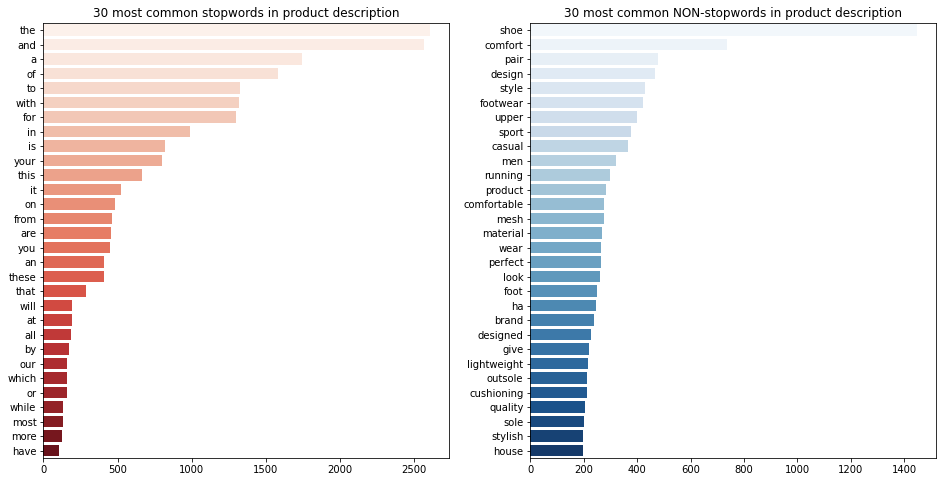

In [26]:
stop_product_description_x, stop_product_description_y = zip(
    *product_description_stop_freq
    )

count_product_description = Counter(create_corpus(df["product_description"]))

product_description_x, product_description_y = zip(
    *count_product_description.most_common(30)
    )

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.barplot(
    y=list(stop_product_description_x)[:30],
    x=list(stop_product_description_y)[:30],
    orient="h", palette="Reds", ax=ax[0]
    )
sns.barplot(
    y=list(product_description_x),
    x=list(product_description_y),
    orient="h", palette="Blues", ax=ax[1]
    )

ax[0].title.set_text("30 most common stopwords in product description")
ax[1].title.set_text("30 most common NON-stopwords in product description")

Посмотрим на статистику для столбцов price, rating и total reviews.

In [27]:
df.describe()

,price,rating,total_reviews
count,1015.000000,1015.000000,1015.000000
mean,1789.546788,3.941379,783.252217
std,1564.919370,0.426353,3034.054929
min,127.000000,1.000000,1.000000
25%,569.000000,3.800000,27.000000
50%,1399.000000,4.000000,123.000000
75%,2403.500000,4.200000,455.500000
max,7992.000000,5.000000,42193.000000


Посмотрим, сколько товаров получили положительную оценку (рейтинг >= 3.5), а сколько — отрицательную (рейтинг < 3.5).

In [28]:
df["sentiment"] = df["rating"].apply(lambda x: "neg" if x < 3.5 else "pos")

In [29]:
df["sentiment"].value_counts()

pos    914
neg    101
Name: sentiment, dtype: int64

Нарисуем облака слов для товаров с положительной и отрицательной оценкой.

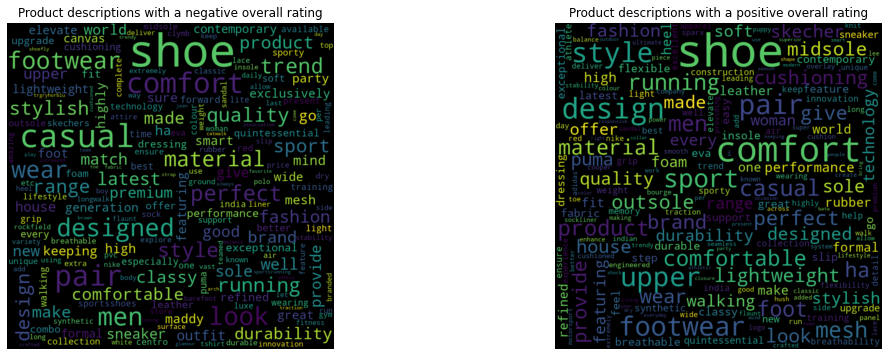

In [30]:
neg_words = " ".join(
    [text for text in df[df["sentiment"]=="neg"]["product_description"]]
    )
wordcloud_neg = WordCloud(
    width=800, height=800, random_state=42,
    collocations=False, max_font_size=110
    ).generate(neg_words)

pos_words = " ".join(
    [text for text in df[df["sentiment"]=="pos"]["product_description"]]
    )
wordcloud_pos = WordCloud(
    width=800, height=800, random_state=42,
    collocations=False, max_font_size=110
    ).generate(pos_words)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(wordcloud_neg, interpolation="bilinear")
ax[1].imshow(wordcloud_pos, interpolation="bilinear")
ax[0].axis("off")
ax[1].axis("off")
ax[0].title.set_text("Product descriptions with a negative overall rating")
ax[1].title.set_text("Product descriptions with a positive overall rating")

Построим гистограммы цены и рейтинга для товаров с положительной и отрицательной оценкой.

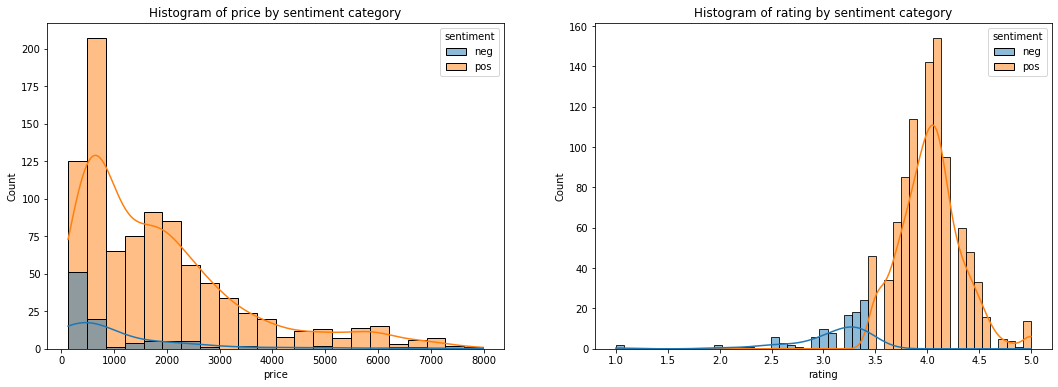

In [31]:
fig, ax = plt.subplots(1, 2)
sns.histplot(x=df["price"], hue=df["sentiment"], kde=True, ax=ax[0])
sns.histplot(x=df["rating"], hue=df["sentiment"], kde=True, ax=ax[1])

ax[0].title.set_text("Histogram of price by sentiment category")
ax[1].title.set_text("Histogram of rating by sentiment category")

Построим диаграмму размаха цены для товаров, получивших положительную и отрицательную оценку.

Text(0.5, 1.0, 'Price by sentiment category')

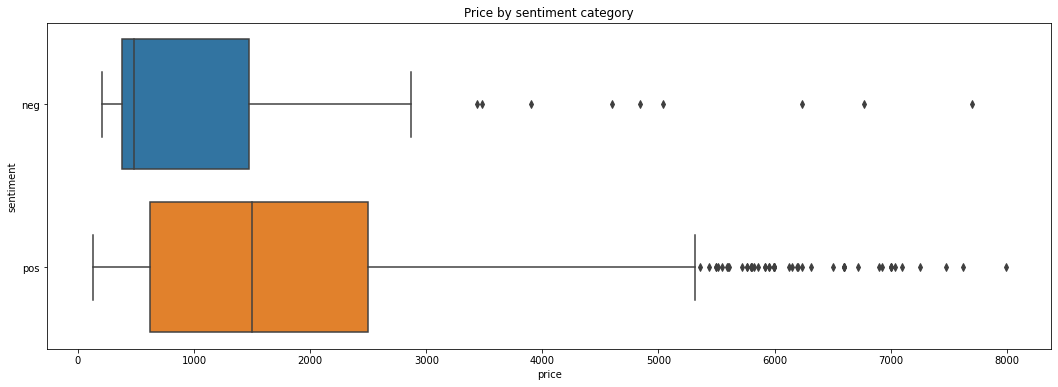

In [32]:
sns.boxplot(x=df["price"], y=df["sentiment"])

plt.title("Price by sentiment category")

Оба графика показывают, что отрицательную оценку получили в основном товары с низкой ценой.<br>
Посмотрим на 5 самых дорогих и самых дешёвых товара.

In [33]:
df.sort_values(by="price").nlargest(5, "price")

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type,sentiment
798,Saucony Men's Canyon Tr Trail Running Shoe,7992.0,4.4,22,looking add variety workout routine canyon tr ...,well cushioned trail shoes|| verified purchase...,5.0 out of 5 stars|| 4.0 out of 5 stars|| 4.0 ...,Men,pos
1009,Converse Unisex-Adult Sneakers,7702.0,1.0,1,converse change started court got adopted stre...,colour is not good,1.0 out of 5 stars,Women,neg
784,Nike Men's Cortez Basic Premium Iron Grey/Whit...,7621.0,4.6,55,step bold new world inspired bill bowermans fi...,verified purchase|| verified purchase|| verifi...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men,pos
1013,Nike Women's WMNS Air Zoom Pegasus 37 Running ...,7480.0,4.5,67,nike k nike woman running shoe feel even look ...,verified purchase|| verified purchase|| verifi...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 4.0 ...,Women,pos
1010,Nike Men's React Vision Running Shoes,7256.0,4.4,200,nike react vision story surreal comfort layere...,must buy|| not have a great fiting but great q...,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Women,pos


In [34]:
df.sort_values(by="price").nsmallest(5, "price")

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type,sentiment
854,Flite Women's Flip-Flops,127.0,4.2,22140,sparx present footwear range keep foot great e...,comfortable light and sturdy buy one size bigg...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 4.0 ...,Women,pos
56,Relaxo Men's Gybk House Slippers - 8 UK/India ...,129.0,4.3,1469,sparx present footwear range keep foot great e...,do not buy|| excellent pair of sleeper receive...,1.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men,pos
21,Paragon Men's Flip-Flops,132.0,4.2,16821,part paragon paralite range footwear paralite ...,low cost but not upto my expectations|| best p...,3.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men,pos
821,Paragon Women's Fashion Sandals,142.0,4.1,7702,trendy paragon flip flop slipper woman comfort...,five star product|| nice|| awesome|| magical i...,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Women,pos
47,Sparx Men's Nt0004g Formal Shoes,155.0,3.6,202,light weight rubber sole excellent grip sparx ...,got a different brand|| pls give me my order||...,3.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men,pos


Посмотрим на взаимоотношения между численными признаками — ценой, рейтингом и количеством отзывов.

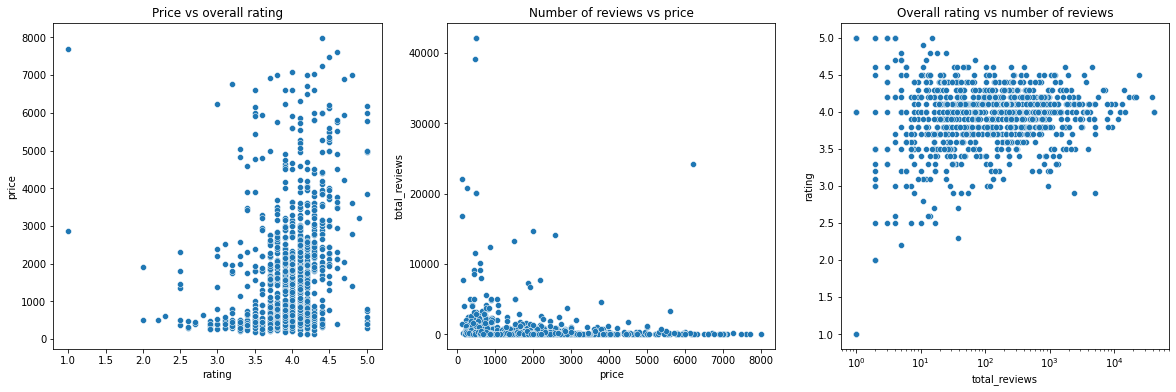

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
sns.scatterplot(x=df["rating"], y=df["price"], ax=ax[0])
sns.scatterplot(x=df["price"], y=df["total_reviews"], ax=ax[1])
sns.scatterplot(x=df["total_reviews"], y=df["rating"], ax=ax[2])

ax[0].title.set_text("Price vs overall rating")
ax[1].title.set_text("Number of reviews vs price")
ax[2].title.set_text("Overall rating vs number of reviews")
ax[2].set_xscale("log")

Text(0.5, 1.0, 'Price, overall rating, number of reviews: correlation matrix')

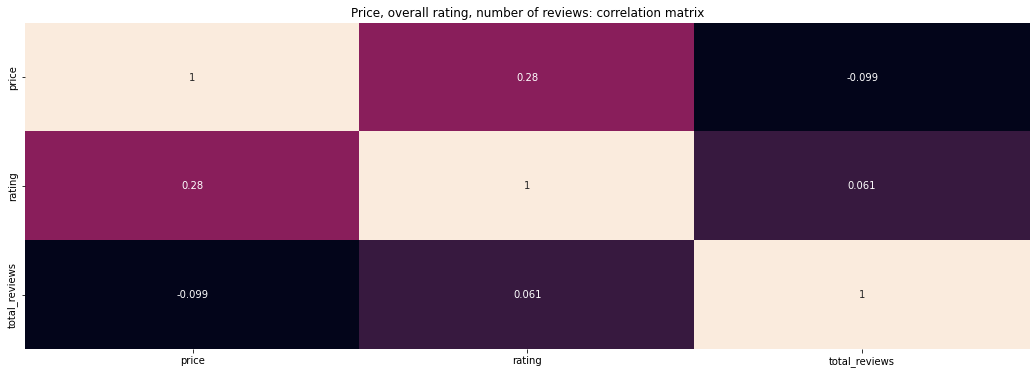

In [36]:
sns.heatmap(df.select_dtypes(exclude="object").corr(), annot=True, cbar=False)

plt.title("Price, overall rating, number of reviews: correlation matrix")

Графики показывают, что цена как-то связана с рейтингом. Больше никаких взаимосвязей между численными признаками нет.<br>
Посмотрим, товары каких брендов встречаются в датасете. Заметим, что названия товаров почти всегда начинаются с названия бренда, за которым через пробел следует описание типа обуви или серийный номер.

In [37]:
words = ["men", "women", "unisex", "boy", "girl", "kid", "socks", "jogging",
         "cast", "walking", "fashionable", "military", "outdoor", "airstrike",
         "polyester", "drive", "orange", "black", "bobs", "safety",
         "multicolor", "by", "puremotion", "neo", "combo", "ac", "sports",
         "brand", "mesh", "zeus", "cognac", "premium", "stylish", "ignite",
         "shoes", "formal", "open", "running", "canvas", "cool", "white",
         "high", "series", "sneakers", "fortune", "gliders", "warrior", "cell",
         "clasp", "dryflex", "propel", "softride", "casual", "leather",
         "springer", "classics", "original", "go", "synthetic", "uniform",
         "footwear", "extra"]

In [38]:
regex = r"(.*?) (\w*-)?(\w*\d+|" + "|".join(words) + ")"

In [39]:
def find_brand(title: str) -> str:
    """
    Функция, которая находит название бренда
    в названии товара и возвращает название бренда в нижнем регистре.
    Если бренда нет, то возвращает пустую строку.

    Parameters:
        title: str

    Returns:
        str
    """
    title = title.lower()
    # здесь бренда нет
    if title.split()[0] in ["army", "men's", "twins"]:
        return ""
    # здесь бренд не в начале строки
    elif title.startswith("mens joyride"):
        return "joyride"
    # здесь бренд пропущен
    elif title.startswith("hy-court 2.0"):
        return "nivia"
    # здесь строка состоит только из названия бренда
    elif title == "sparx":
        return "sparx"
    # здесь бренд написан неправильно
    elif title.startswith("redchief"):
        return "red chief"
    # здесь после названия бренда идёт символ ®, который нужно убрать
    elif title.find("®") != -1:
        return title[:title.find("®")]
    return re.match(regex, title).group(1)

In [40]:
brands = np.array([find_brand(title) for title in df["title"]])

np.unique(brands)

array(['', '2row', 'a antic mop', 'aadi', 'action', 'adidas', 'advick',
       'aircum', 'ak sky', 'all safe', 'allen cooper', 'amazon', 'amico',
       'aqualite', 'arrow', 'asian', 'asics', 'athleo', 'b.r.k.',
       'bacca bucci', 'bata', 'belini', 'bella toes', 'beonza',
       'bmcitybm', 'bond street', 'bonexy', 'bourge', 'brooks anthem',
       'bugatti', 'burwood', 'bxxy', 'camfoot', 'campus',
       'carlton london', 'catwalk', 'centrino', 'centro', 'chevit',
       'clarks', 'clymb', 'colo', 'columbia', 'converse', 'crkas',
       'crocs', 'd', "d'use", 'd-sneakerz', 'dare', 'denill', 'dock',
       'earth step', 'elise', 'enjoy', 'ethics', 'fentacia', 'feroc adf',
       'fitshoe', 'flavia', 'flite', 'flite pu', 'furiozz', 'furo',
       'fusefit', 'goldstar', 'gwal g', 'himquen', 'hummel',
       'hush puppies', 'inklenzo', 'joyride', 'kavon', 'klepe', 'knoos',
       'kraasa', 'krafter', 'lancer', 'layasa ayasa', 'lee cooper',
       'leone', 'liberty', 'longwalk', 'lotto'

In [41]:
df.insert(0, "brand", brands)

Построим график средней цены в зависимости от бренда.

Text(0.5, 0, 'Mean price by brand, ₹')

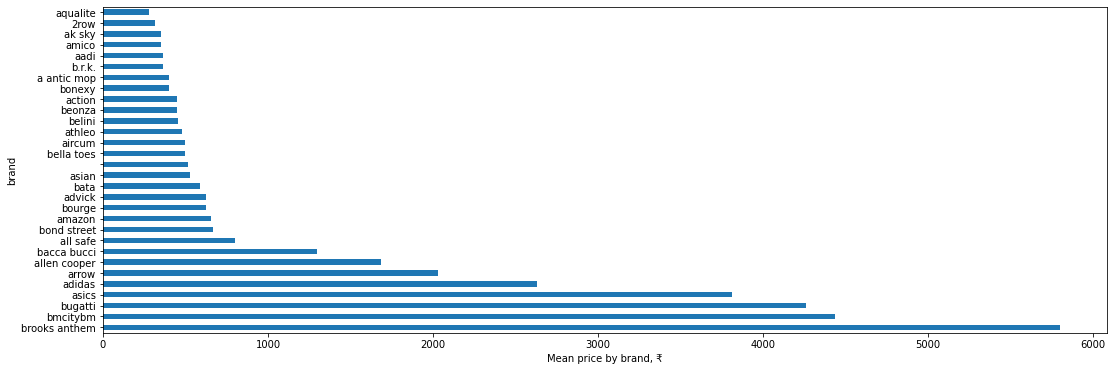

In [42]:
df.groupby("brand").mean()["price"][:30].sort_values(ascending=False).plot(
    kind="barh")

plt.xlabel("Mean price by brand, ₹")

Посмотрим на количество слов в описаниях товаров.

In [43]:
df.insert(
    6, "product_description_n_words",
    df["product_description"].apply(lambda x: len(x.split()))
    )

Text(0, 0.5, 'Number of words')

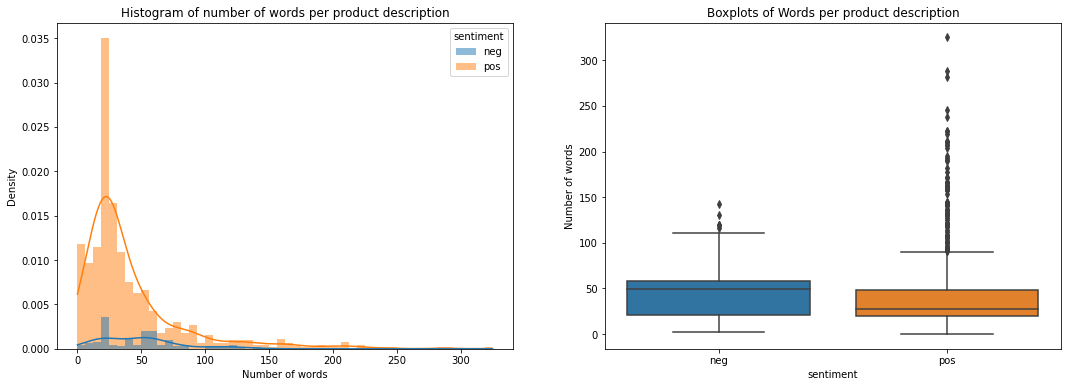

In [44]:
fig, ax = plt.subplots(1, 2)

sns.histplot(x=df["product_description_n_words"], hue=df["sentiment"], 
             kde=True, stat='density', linewidth=0, ax=ax[0])
sns.boxplot(y=df["product_description_n_words"], x=df["sentiment"], ax=ax[1])

ax[0].set_title("Histogram of number of words per product description")
ax[0].set_xlabel("Number of words")
ax[1].set_title("Boxplots of Words per product description")
ax[1].set_xlabel("sentiment")
ax[1].set_ylabel("Number of words")

Посмотрим на среднюю длину слов в описаниях товаров.

In [45]:
df.insert(
    7, "product_description_avg_word_len",
    df["product_description"].apply(
        lambda x: np.sum([len(w) for w in x.split()]) / len(x.split())
        )
    )

Text(0, 0.5, 'Average word length')

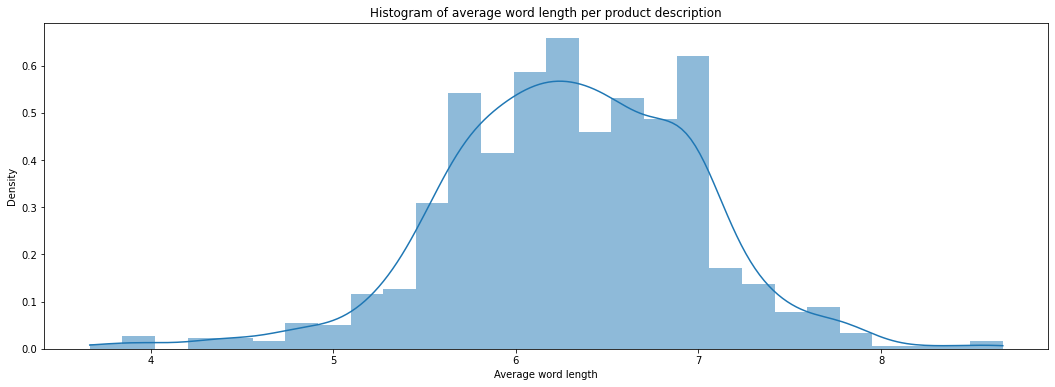

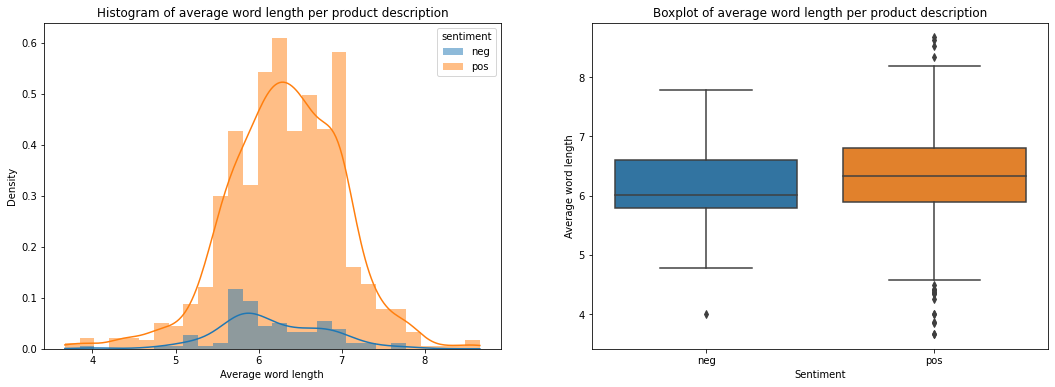

In [46]:
sns.histplot(
    df["product_description_avg_word_len"], kde=True, stat="density",
    linewidth=0
    )
plt.title("Histogram of average word length per product description")
plt.xlabel("Average word length")

fig, ax = plt.subplots(1, 2)
sns.histplot(x=df["product_description_avg_word_len"], hue=df["sentiment"], 
             kde=True, stat="density", linewidth=0, ax=ax[0])
sns.boxplot(
    y=df["product_description_avg_word_len"], x=df["sentiment"], ax=ax[1]
    )

ax[0].set_title("Histogram of average word length per product description")
ax[0].set_xlabel("Average word length")
ax[1].set_title("Boxplot of average word length per product description")
ax[1].set_xlabel("Sentiment")
ax[1].set_ylabel("Average word length")

#### **Векторизация**
Нормализуем значения столбца price.

In [47]:
df["price"] = (df["price"] - np.mean(df["price"])) / np.std(df["price"])

Разбиваем выборку на обучающую и тестовую в пропорции 3:1.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    df["product_description"], df["price"], random_state=42
    )

In [26]:
def bow_vectorize(X):
    """
    Функция получает на вход массив текстов, обучает на них
    CountVectorizer и возвращает векторизованные тексты
    и обученный CountVectorizer.

    Parameters:
        X: iterable

    Returns:
        array of shape (n_samples, n_features)
        CountVectorizer
    """
    vectorizer = CountVectorizer(min_df=5, max_df=0.4)
    vectors = vectorizer.fit_transform(X)
    return vectors, vectorizer

def tfidf_vectorize(X):
    """
    Функция получает на вход массив текстов, обучает на них
    TfidfVectorizer и возвращает векторизованные тексты
    и обученный TfidfVectorizer.

    Parameters:
        X: iterable

    Returns:
        array of shape (n_samples, n_features)
        TfidfVectorizer
    """
    vectorizer = TfidfVectorizer(min_df=5, max_df=0.4)
    vectors = vectorizer.fit_transform(X)
    return vectors, vectorizer

def combine_vectorizers(X):
    """
    Функция получает на вход массив текстов, обучает на них
    CountVectorizer и TfidfVectorizer, возвращает конкатенацию
    двух матриц и оба обученных векторайзера.

    Parameters:
        X: iterable

    Returns:
        sparse matrix
        CountVectorizer
        TfidfVectorizer
    """
    bow_vectorizer = CountVectorizer(
        max_features=1000, min_df=5, max_df=0.4, ngram_range=(1, 2)
        )
    tfidf_vectorizer = TfidfVectorizer(
        max_features=1000, min_df=5, max_df=0.4, ngram_range=(3, 3),
        analyzer="char"
        )
    bow_vectors = bow_vectorizer.fit_transform(X)
    tfidf_vectors = tfidf_vectorizer.fit_transform(X)
    vectors = hstack([bow_vectors, tfidf_vectors])
    return vectors, bow_vectorizer, tfidf_vectorizer

In [50]:
# bag-of-words
X_train_bow, bow_vectorizer = bow_vectorize(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# TF-IDF
X_train_tfidf, tfidf_vectorizer = tfidf_vectorize(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [51]:
X_train_hstack, bow_vectorizer, tfidf_vectorizer = combine_vectorizers(X_train)
X_test_hstack = hstack(
    [bow_vectorizer.transform(X_test), tfidf_vectorizer.transform(X_test)]
    )

#### **Подбор гиперпараметров и поиск наилучшей модели**
Чтобы сэкономить время и не обучать много разных регрессоров, возьмём SGDRegressor. В зависимости от значения параметра loss он может быть как линейной регрессией, так и SVR, а регуляризация регулируется параметрами penalty и l1_ratio.

In [52]:
regressor = SGDRegressor()

In [53]:
param_grid = [
              {
                  "loss": ["squared_error"],
                  "penalty": ["elasticnet"],
                  "alpha": [1e0, 0.1, 1e-2, 1e-3],
                  "l1_ratio": [0, 0.25, 0.5, 0.75, 1],
                  "fit_intercept": [True, False],
                  "random_state": [42],
                  "early_stopping": [True]
              },
              {
                  "loss": ["huber", "epsilon_insensitive",
                           "squared_epsilon_insensitive"],
                  "penalty": ["elasticnet"],
                  "alpha": [1e0, 0.1, 1e-2, 1e-3],
                  "l1_ratio": [0, 0.25, 0.5, 0.75, 1],
                  "fit_intercept": [True, False],
                  "epsilon": [0.5, 0.1, 0.01],
                  "random_state": [42],
                  "early_stopping": [True]
              }
]

In [54]:
cv_bow = GridSearchCV(regressor, param_grid, n_jobs=-1, verbose=2)

In [55]:
cv_bow.fit(X_train_bow, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


GridSearchCV(estimator=SGDRegressor(), n_jobs=-1,
             param_grid=[{'alpha': [1.0, 0.1, 0.01, 0.001],
                          'early_stopping': [True],
                          'fit_intercept': [True, False],
                          'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                          'loss': ['squared_error'], 'penalty': ['elasticnet'],
                          'random_state': [42]},
                         {'alpha': [1.0, 0.1, 0.01, 0.001],
                          'early_stopping': [True], 'epsilon': [0.5, 0.1, 0.01],
                          'fit_intercept': [True, False],
                          'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                          'loss': ['huber', 'epsilon_insensitive',
                                   'squared_epsilon_insensitive'],
                          'penalty': ['elasticnet'], 'random_state': [42]}],
             verbose=2)

In [56]:
cv_bow.best_params_

{'alpha': 0.001,
 'early_stopping': True,
 'epsilon': 0.01,
 'fit_intercept': False,
 'l1_ratio': 0,
 'loss': 'squared_epsilon_insensitive',
 'penalty': 'elasticnet',
 'random_state': 42}

In [57]:
cv_bow.best_score_

0.4630420151930964

In [58]:
regressor = SGDRegressor()

In [59]:
cv_tfidf = GridSearchCV(regressor, param_grid, n_jobs=-1, verbose=2)

In [60]:
cv_tfidf.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


GridSearchCV(estimator=SGDRegressor(), n_jobs=-1,
             param_grid=[{'alpha': [1.0, 0.1, 0.01, 0.001],
                          'early_stopping': [True],
                          'fit_intercept': [True, False],
                          'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                          'loss': ['squared_error'], 'penalty': ['elasticnet'],
                          'random_state': [42]},
                         {'alpha': [1.0, 0.1, 0.01, 0.001],
                          'early_stopping': [True], 'epsilon': [0.5, 0.1, 0.01],
                          'fit_intercept': [True, False],
                          'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                          'loss': ['huber', 'epsilon_insensitive',
                                   'squared_epsilon_insensitive'],
                          'penalty': ['elasticnet'], 'random_state': [42]}],
             verbose=2)

In [61]:
cv_tfidf.best_params_

{'alpha': 0.001,
 'early_stopping': True,
 'epsilon': 0.1,
 'fit_intercept': True,
 'l1_ratio': 0.75,
 'loss': 'squared_epsilon_insensitive',
 'penalty': 'elasticnet',
 'random_state': 42}

In [62]:
cv_tfidf.best_score_ # TF-IDF лучше!

0.4228063725441314

In [63]:
regressor = SGDRegressor()

In [64]:
cv_hstack = GridSearchCV(regressor, param_grid, n_jobs=-1, verbose=2)

In [65]:
cv_hstack.fit(X_train_hstack, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


GridSearchCV(estimator=SGDRegressor(), n_jobs=-1,
             param_grid=[{'alpha': [1.0, 0.1, 0.01, 0.001],
                          'early_stopping': [True],
                          'fit_intercept': [True, False],
                          'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                          'loss': ['squared_error'], 'penalty': ['elasticnet'],
                          'random_state': [42]},
                         {'alpha': [1.0, 0.1, 0.01, 0.001],
                          'early_stopping': [True], 'epsilon': [0.5, 0.1, 0.01],
                          'fit_intercept': [True, False],
                          'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                          'loss': ['huber', 'epsilon_insensitive',
                                   'squared_epsilon_insensitive'],
                          'penalty': ['elasticnet'], 'random_state': [42]}],
             verbose=2)

In [66]:
cv_hstack.best_params_

{'alpha': 0.001,
 'early_stopping': True,
 'fit_intercept': False,
 'l1_ratio': 0.25,
 'loss': 'squared_error',
 'penalty': 'elasticnet',
 'random_state': 42}

In [67]:
cv_hstack.best_score_

0.4619348971354218

Во всех трёх случаях метод опорных векторов, как и ожидалось, показал лучшие результаты, чем линейная регрессия.<br>
Также во всех трёх случаях наилучшим значением epsilon оказалось наименьшее — 0.01. Чем меньше epsilon, тем более чувствительна к отклонению от предсказанного значения лосс-функция нашей модели.<br>
Для регрессора, обученного на векторах TF-IDF, потребовалась самая слабая регуляризация (alpha=0.001), при этом значение функции потерь у него ниже, чем у других двух регрессоров.

#### **Оценка качества модели**
Прежде, чем считать значение RMSE для предсказаний нашей модели на тестовых данных, посчитаем это значение для случайного и среднего предсказания.

In [68]:
np.sqrt(mean_squared_error(y_test, np.random.rand(len(y_test))))

1.168270948297057

In [69]:
np.sqrt(mean_squared_error(y_test, np.full(len(y_test), np.mean(y_train))))

1.0033918153387826

Получаем предсказания нашей модели на тестовой выборке, считаем RMSE и коэффициент детерминации.

In [70]:
preds = cv_tfidf.best_estimator_.predict(X_test_tfidf)

In [71]:
np.sqrt(mean_squared_error(y_test, preds))

0.8066030838822378

In [73]:
r2_score(y_test, preds)

0.3519322101433241

RMSE ниже, чем у случайного и среднего предсказания, а коэффициент детерминации между 0 и 1. Уже хорошо.<br>
Построим график с предсказаниями модели и истинными значениями тестовой выборки.

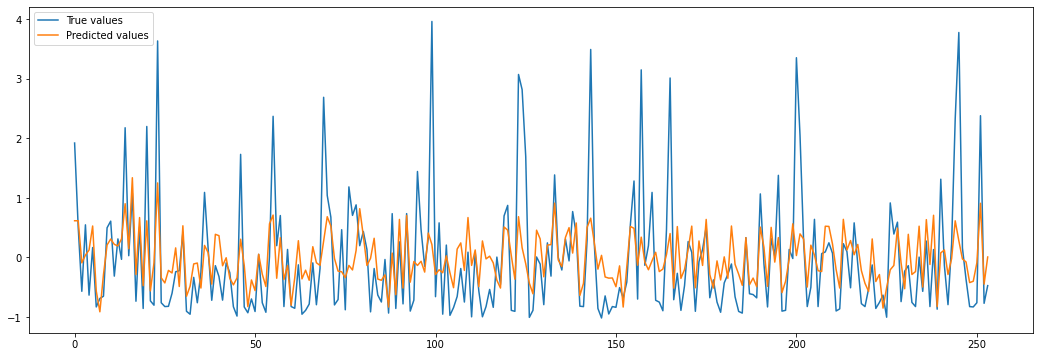

In [75]:
plt.plot(range(len(y_test)), y_test, label='True values')
plt.plot(range(len(y_test)), preds, label='Predicted values')
plt.legend()
plt.show()

У истинных значений разброс выше, чем у предсказанных.

### **Задание 2.** 
Предсказать оценку товара пользователем по его отзыву (для каждого отзыва)

#### **Препроцессинг**
Собираем датасет отзывов.

In [27]:
df_reviews = pd.DataFrame(
    list(zip(
        "|| ".join(df["reviews"].values).split("|| "),
        "|| ".join(df["reviews_rating"].values).split("|| ")
        )), columns=["review", "rating"]
    )

In [28]:
# у нас задача классификации, поэтому преобразуем рейтинг в int

df_reviews["rating"] = df_reviews["rating"].str[:1].astype(int)

In [29]:
df_reviews.head()

,review,rating
0,happy product,1
1,expected,1
2,average product,3
3,pic beautiful,3
4,got damage product quality average,3


Найдём самые частые отзывы.

In [30]:
df_reviews["review"].value_counts()

verified purchase          429
good                       362
report abuse               199
good product               176
nice                       134
                          ... 
low quality dont buy it      1
ok ok quality good all       1
mrp printed shoe sold        1
good ok product              1
asics shoe best              1
Name: review, Length: 4226, dtype: int64

"Verified purchase" и "report abuse" — это явно какие-то автоматические тексты, поэтому строки с ними мы удаляем.

In [31]:
df_reviews = df_reviews[(df_reviews["review"] != "verified purchase") & (df_reviews["review"] != "report abuse")]

In [32]:
df_reviews["review"].value_counts()

good                       362
good product               176
nice                       134
value money                108
comfortable                 99
                          ... 
low quality dont buy it      1
ok ok quality good all       1
mrp printed shoe sold        1
good ok product              1
asics shoe best              1
Name: review, Length: 4224, dtype: int64

In [33]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7566 entries, 0 to 8193
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  7566 non-null   object
 1   rating  7566 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 177.3+ KB


#### **Анализ данных**
Посмотрим на распределение оценок.

In [34]:
df_reviews["rating"].value_counts(sort=False)

1    1453
3     681
2     451
5    3497
4    1484
Name: rating, dtype: int64

Text(0.5, 1.0, 'Histogram of review ratings')

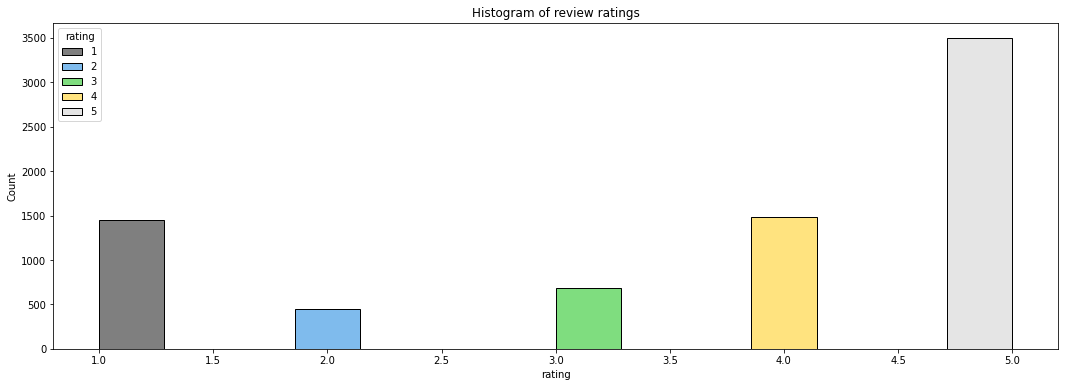

In [35]:
sns.histplot(
    x=df_reviews["rating"], hue=df_reviews["rating"],
    kde=True, palette=mpl.cm.nipy_spectral
    )
plt.title("Histogram of review ratings")

Посмотрим на то, какие слова чаще всего встречаются в текстах отзывов.

Text(0.5, 1.0, '30 most common words in reviews')

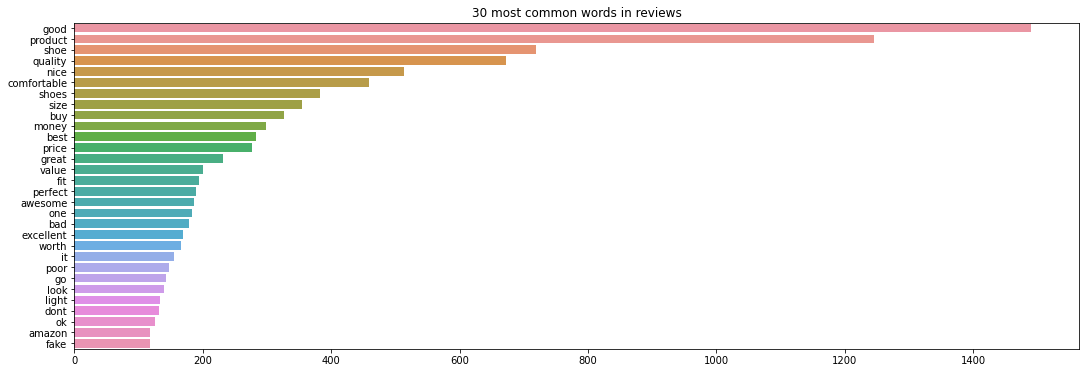

In [36]:
count_review = Counter(create_corpus(df_reviews["review"]))
review_x, review_y = zip(*count_review.most_common(30))
sns.barplot(y=list(review_x), x=list(review_y), orient="h")
plt.title("30 most common words in reviews")

Нарисуем облака слов для текстов отзывов — как всех отзывов в сумме, так и поклассово.

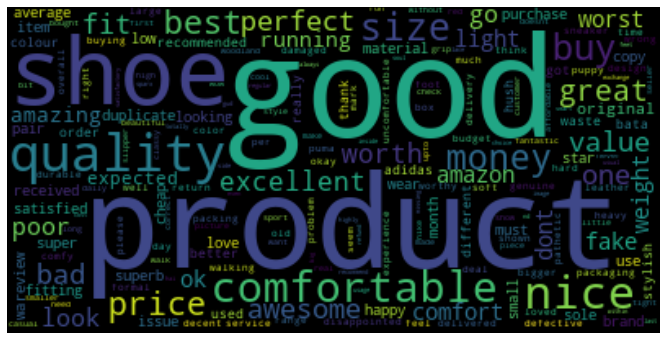

In [37]:
wordcloud = WordCloud(
    collocations=False, random_state=42
    ).generate(" ".join(df_reviews["review"]))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

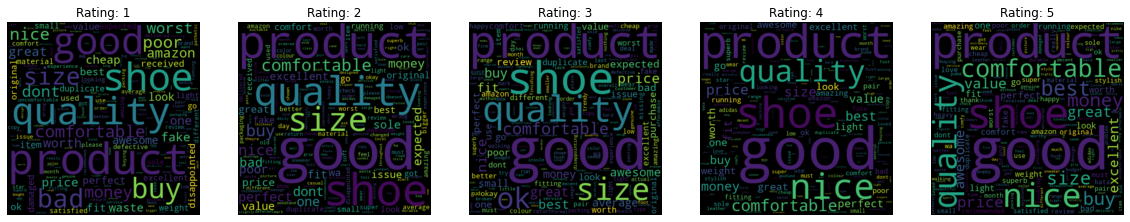

In [38]:
wordcloud_1 = WordCloud(
    width=500, height=500, collocations=False, random_state=42
    ).generate(" ".join(df_reviews[df_reviews["rating"] == 1]["review"]))

wordcloud_2 = WordCloud(
    width=500, height=500, collocations=False, random_state=42
    ).generate(" ".join(df_reviews[df_reviews["rating"] == 2]["review"]))

wordcloud_3 = WordCloud(
    width=500, height=500, collocations=False, random_state=42
    ).generate(" ".join(df_reviews[df_reviews["rating"] == 3]["review"]))

wordcloud_4 = WordCloud(
    width=500, height=500, collocations=False, random_state=42
    ).generate(" ".join(df_reviews[df_reviews["rating"] == 4]["review"]))

wordcloud_5 = WordCloud(
    width=500, height=500, collocations=False, random_state=42
    ).generate(" ".join(df_reviews[df_reviews["rating"] == 5]["review"]))

fig, ax = plt.subplots(1, 5, figsize=(20, 20))
ax[0].imshow(wordcloud_1, interpolation="bilinear")
ax[1].imshow(wordcloud_2, interpolation="bilinear")
ax[2].imshow(wordcloud_3, interpolation="bilinear")
ax[3].imshow(wordcloud_4, interpolation="bilinear")
ax[4].imshow(wordcloud_5, interpolation="bilinear")
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
ax[3].axis("off")
ax[4].axis("off")
ax[0].title.set_text("Rating: 1")
ax[1].title.set_text("Rating: 2")
ax[2].title.set_text("Rating: 3")
ax[3].title.set_text("Rating: 4")
ax[4].title.set_text("Rating: 5")

Посмотрим на длину отзывов.

In [39]:
df_reviews.insert(
    1, "n_words", df_reviews["review"].apply(lambda x: len(x.split()))
    )

Text(0, 0.5, 'Number of words')

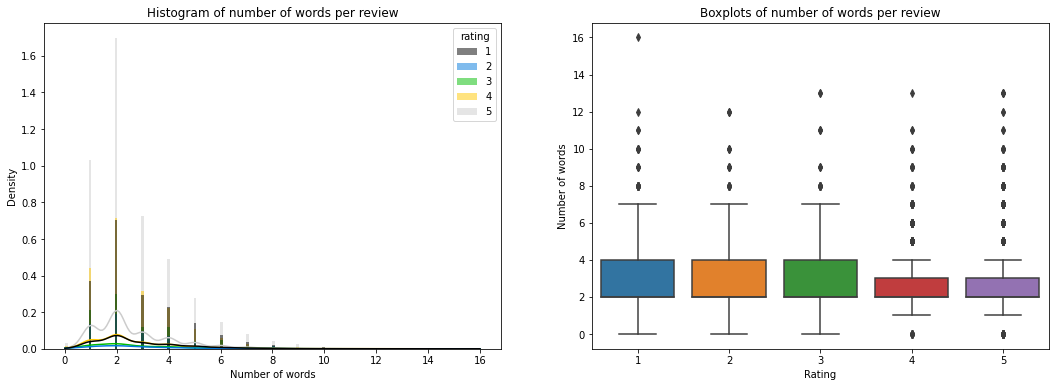

In [40]:
fig, ax = plt.subplots(1, 2)

sns.histplot(x=df_reviews["n_words"], hue=df_reviews["rating"], 
             kde=True, palette=mpl.cm.nipy_spectral, stat='density',
             linewidth=0, ax=ax[0])
sns.boxplot(y=df_reviews["n_words"], x=df_reviews["rating"], ax=ax[1])

ax[0].set_title("Histogram of number of words per review")
ax[0].set_xlabel("Number of words")
ax[1].set_title("Boxplots of number of words per review")
ax[1].set_xlabel("Rating")
ax[1].set_ylabel("Number of words")

Посмотрим на среднюю длину слов в отзыве.

In [41]:
df_reviews.insert(
    2, "avg_word_len", df_reviews["review"].apply(
        lambda x: np.sum([len(w) for w in x.split()]) / len(x.split())
        )
    )

Text(0, 0.5, 'Average word length')

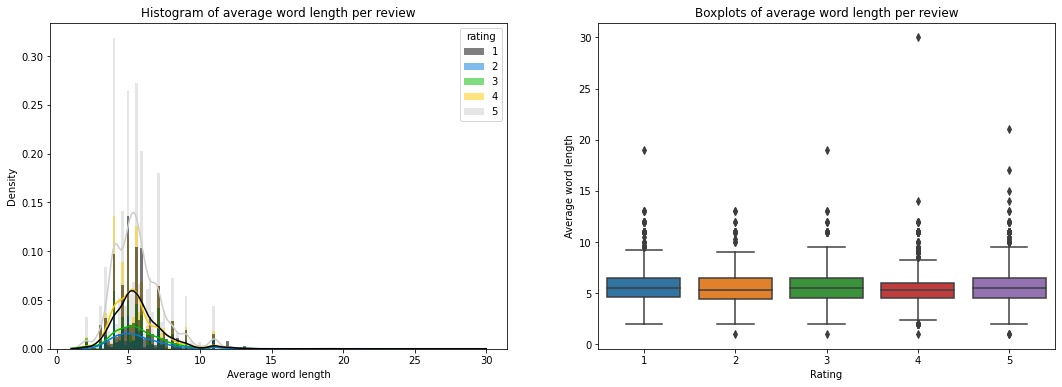

In [42]:
fig, ax = plt.subplots(1, 2)

sns.histplot(x=df_reviews["avg_word_len"], hue=df_reviews["rating"], 
             kde=True, palette=mpl.cm.nipy_spectral, stat='density',
             linewidth=0, ax=ax[0])
sns.boxplot(y=df_reviews["avg_word_len"], x=df_reviews["rating"], ax=ax[1])

ax[0].set_title("Histogram of average word length per review")
ax[0].set_xlabel("Average word length")
ax[1].set_title("Boxplots of average word length per review")
ax[1].set_xlabel("Rating")
ax[1].set_ylabel("Average word length")

#### **Векторизация**
Разбиваем выборку на обучающую и тестовую в пропорции 3:1.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    df_reviews["review"], df_reviews["rating"], random_state=42
    )

In [44]:
# bag-of-words
X_train_bow, bow_vectorizer = bow_vectorize(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# TF-IDF
X_train_tfidf, tfidf_vectorizer = tfidf_vectorize(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#### **Подбор гиперпараметров и поиск наилучшей модели**
Для классификации отзывов я решила попробовать 3 модели:<br>
* **Multinomial Naive Bayes**
* **Logistic Regression**
* **Support Vector Classifier**

Все три алгоритма хорошо справляются с задачей классификации текстов.<br>
Я не использовала модели, основанные на деревьях решений (**Decision Tree Classifier** и **Random Forest Classifier**), потому что деревья решений плохо работают на sparse матрицах с высокой размерностью (а эмбеддинги текстов — это sparse матрицы с высокой размерностью).<br>

In [45]:
param_grid_naive_bayes = {
    "alpha": [1e0, 0.1, 1e-2, 1e-3],
    "fit_prior": [True, False]
}

In [54]:
clf = MultinomialNB()

In [55]:
naive_bayes_bow = GridSearchCV(
    clf, param_grid_naive_bayes, scoring="accuracy", n_jobs=-1, verbose=2)

In [56]:
naive_bayes_bow.fit(X_train_bow, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [1.0, 0.1, 0.01, 0.001],
                         'fit_prior': [True, False]},
             scoring='accuracy', verbose=2)

In [57]:
naive_bayes_bow.best_params_

{'alpha': 1.0, 'fit_prior': True}

In [58]:
naive_bayes_bow.best_score_

0.44659938310452263

In [59]:
clf = MultinomialNB()

In [60]:
naive_bayes_tfidf = GridSearchCV(
    clf, param_grid_naive_bayes, scoring="accuracy", n_jobs=-1, verbose=2)

In [61]:
naive_bayes_tfidf.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [1.0, 0.1, 0.01, 0.001],
                         'fit_prior': [True, False]},
             scoring='accuracy', verbose=2)

In [62]:
naive_bayes_tfidf.best_params_

{'alpha': 1.0, 'fit_prior': True}

In [63]:
naive_bayes_tfidf.best_score_

0.46034620733592835

**Naive Bayes Classifier** в обоих случаях работает лучше всего с дефолтными параметрами и даёт не очень высокий accuracy_score (0.46 на tf-idf эмбеддингах против 0.45 на bag-of-words).

In [68]:
param_grid_logreg = [
                     {
                         "solver": ["newton-cg", "lbfgs", "sag"],
                         "penalty": ["l2", "none"],
                         "C": [0.01, 0.1, 1.0, 10, 100],
                         "fit_intercept": [True, False],
                         "random_state": [42]
                     },
                     {
                         "solver": ["liblinear"],
                         "penalty": ["l1", "l2"],
                         "C": [0.01, 0.1, 1.0, 10, 100],
                         "fit_intercept": [True, False],
                         "random_state": [42]
                     },
                     {
                         "solver": ["saga"],
                         "penalty": ["l1", "l2", "none"],
                         "C": [0.01, 0.1, 1.0, 10, 100],
                         "fit_intercept": [True, False],
                         "random_state": [42]
                     }
]

In [69]:
clf = LogisticRegression()

In [70]:
logreg_bow = GridSearchCV(
    clf, param_grid_logreg, scoring="accuracy", n_jobs=-1, verbose=2
    )

In [71]:
logreg_bow.fit(X_train_bow, y_train)

Fitting 5 folds for each of 110 candidates, totalling 550 fits


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1.0, 10, 100],
                          'fit_intercept': [True, False],
                          'penalty': ['l2', 'none'], 'random_state': [42],
                          'solver': ['newton-cg', 'lbfgs', 'sag']},
                         {'C': [0.01, 0.1, 1.0, 10, 100],
                          'fit_intercept': [True, False],
                          'penalty': ['l1', 'l2'], 'random_state': [42],
                          'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1.0, 10, 100],
                          'fit_intercept': [True, False],
                          'penalty': ['l1', 'l2', 'none'], 'random_state': [42],
                          'solver': ['saga']}],
             scoring='accuracy', verbose=2)

In [72]:
logreg_bow.best_params_

{'C': 0.1,
 'fit_intercept': True,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'newton-cg'}

In [73]:
logreg_bow.best_score_

0.46845302193319815

In [74]:
clf = LogisticRegression()

In [75]:
logreg_tfidf = GridSearchCV(
    clf, param_grid_logreg, scoring="accuracy", n_jobs=-1, verbose=2
    )

In [76]:
logreg_tfidf.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 110 candidates, totalling 550 fits


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1.0, 10, 100],
                          'fit_intercept': [True, False],
                          'penalty': ['l2', 'none'], 'random_state': [42],
                          'solver': ['newton-cg', 'lbfgs', 'sag']},
                         {'C': [0.01, 0.1, 1.0, 10, 100],
                          'fit_intercept': [True, False],
                          'penalty': ['l1', 'l2'], 'random_state': [42],
                          'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1.0, 10, 100],
                          'fit_intercept': [True, False],
                          'penalty': ['l1', 'l2', 'none'], 'random_state': [42],
                          'solver': ['saga']}],
             scoring='accuracy', verbose=2)

In [77]:
logreg_tfidf.best_params_

{'C': 0.1,
 'fit_intercept': True,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'newton-cg'}

In [78]:
logreg_tfidf.best_score_

0.4659855954129082

**Логистическая регрессия**, обученная на bag-of-words векторах, пока что даёт самый лучший результат (accuracy=0.468).

In [79]:
param_grid_svm = [
                  {
                      "kernel": ["linear"],
                      "C": [0.01, 0.1, 1.0, 10, 100]
                   },
                  {
                      "kernel": ["poly", "rbf", "sigmoid"],
                      "C": [0.01, 0.1, 1.0, 10, 100],
                      "gamma": ["scale", 1e0, 0.1, 1e-2, 1e-3]
                   }
]

In [80]:
clf = SVC()

In [81]:
svm_bow = GridSearchCV(
    clf, param_grid_svm, scoring="accuracy", n_jobs=-1, verbose=2
    )

In [82]:
svm_bow.fit(X_train_bow, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1.0, 10, 100], 'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1.0, 10, 100],
                          'gamma': ['scale', 1.0, 0.1, 0.01, 0.001],
                          'kernel': ['poly', 'rbf', 'sigmoid']}],
             scoring='accuracy', verbose=2)

In [83]:
svm_bow.best_params_

{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}

In [84]:
svm_bow.best_score_

0.46510438275489674

In [85]:
clf = SVC()

In [86]:
svm_tfidf = GridSearchCV(
    clf, param_grid_svm, scoring="accuracy", n_jobs=-1, verbose=2
    )

In [87]:
svm_tfidf.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1.0, 10, 100], 'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1.0, 10, 100],
                          'gamma': ['scale', 1.0, 0.1, 0.01, 0.001],
                          'kernel': ['poly', 'rbf', 'sigmoid']}],
             scoring='accuracy', verbose=2)

In [88]:
svm_tfidf.best_params_

{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}

In [89]:
svm_tfidf.best_score_

0.4643996923292078

#### **Оценка качества модели**

In [90]:
preds = logreg_bow.best_estimator_.predict(X_test_bow)

In [92]:
acc = accuracy_score(preds, y_test)
micro_f1 = f1_score(preds, y_test, average="micro")
micro_p = precision_score(preds, y_test, average="micro")
micro_r = recall_score(preds, y_test, average="micro")
macro_f1 = f1_score(preds, y_test, average="macro")
macro_p = precision_score(preds, y_test, average="macro")
macro_r = recall_score(preds, y_test, average="macro")
print(f"acc={acc:1.4f}")
print(f"micro F1={micro_f1:1.4f}, micro P={micro_p:1.4f}, micro R={micro_r:1.4f}")
print(f"macro F1={macro_f1:1.4f}, macro P={macro_p:1.4f}, macro R={macro_r:1.4f}")

acc=0.4778
micro F1=0.4778, micro P=0.4778, micro R=0.4778
macro F1=0.1791, macro P=0.2249, macro R=0.3279


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(141.0, 0.5, 'y_true')

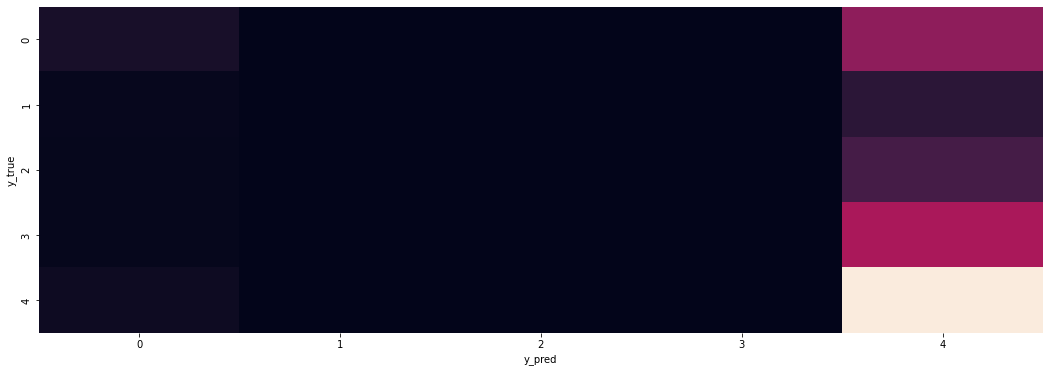

In [93]:
sns.heatmap(confusion_matrix(y_test, preds), cbar=False)
plt.xlabel("y_pred")
plt.ylabel("y_true")